# ADA MidSem P3

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np


# sklearn impots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1 Some helper functions

In [3]:
from pandas.api.types import is_datetime64_dtype, is_categorical_dtype

# helper function to reduce memory usage by compressing datatype
def reduce_mem_usage(df, use_float16=False):
    """ 
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime64_dtype(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 1. Data Loading

In [4]:
%%time

data_path = os.path.join('data', 'raw', 'data_combined.csv')

# read the csv file
df = pd.read_csv(data_path)

CPU times: user 29.9 s, sys: 13.6 s, total: 43.5 s
Wall time: 1min 13s


In [31]:
# show the first 5 rows
df.head()

,frame.number,_ws.col.Time,_ws.col.Source,_ws.col.Destination,_ws.col.Protocol,_ws.col.Length
0,1,0.0,203.77.117.25,204.79.209.209,IPv4,90
1,2,0.000017,202.8.140.26,163.210.224.201,TCP,2962
2,3,0.000027,2404:37ef:c79a:f7d1:c07f:e03f:c037:c096,2001:8a30:7a1a:809d:cffc:d503:83ed:eb9,UDP,1292
3,4,0.000049,202.8.140.26,163.210.224.201,TCP,1514
4,5,0.00006,2404:37ef:c79a:f7d1:c07f:e03f:c037:c096,2001:8a30:7a1a:809d:cffc:d503:83ed:eb9,UDP,1292


In [5]:
# drop the `frame.number` column
df.drop(columns=['frame.number'], inplace=True)

In [33]:
df.head()

,_ws.col.Time,_ws.col.Source,_ws.col.Destination,_ws.col.Protocol,_ws.col.Length
0,0.0,203.77.117.25,204.79.209.209,IPv4,90
1,0.000017,202.8.140.26,163.210.224.201,TCP,2962
2,0.000027,2404:37ef:c79a:f7d1:c07f:e03f:c037:c096,2001:8a30:7a1a:809d:cffc:d503:83ed:eb9,UDP,1292
3,0.000049,202.8.140.26,163.210.224.201,TCP,1514
4,0.00006,2404:37ef:c79a:f7d1:c07f:e03f:c037:c096,2001:8a30:7a1a:809d:cffc:d503:83ed:eb9,UDP,1292


In [35]:
# display the columns of the dataset
df.columns

Index(['_ws.col.Time', '_ws.col.Source', '_ws.col.Destination',
       '_ws.col.Protocol', '_ws.col.Length'],
      dtype='object')

We have 5 columns in our dataset. Here are the desriptions of each column:
- **_ws.col.Time:** Represents the timestamp or time at which the network event was captured.
- **_ws.col.Source:** Represents the source IP address of the network event.
- **_ws.col.Destination:** Represents the destination IP address of the network event.
- **_ws.col.Protocol:** Represents the protocol used for the network event.
- **_ws.col.Length:** Represents the length of the packet in the network event.

## 1.1 Changing data types of columns

In [6]:
# change the datatype of '_ws.col.Time' column to datetime
df['_ws.col.Time'] = pd.to_datetime(df['_ws.col.Time'], errors='coerce')

# change the datatype of '_ws.col.Length' column to int
df['_ws.col.Length'] = pd.to_numeric(df['_ws.col.Length'], errors='coerce')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190037 entries, 0 to 69190036
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   _ws.col.Time         datetime64[ns]
 1   _ws.col.Source       object        
 2   _ws.col.Destination  object        
 3   _ws.col.Protocol     object        
 4   _ws.col.Length       float32       
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 2.3+ GB


## 1.2 Handling Corrupted Data

In [40]:
# check for missing values and inf values

nan_counts = df.isna().sum()
inf_counts = (df == np.inf).sum() + (df == -np.inf).sum()

print('NaN value counts')
print(nan_counts)

print('\nInf value counts')
print(inf_counts)

NaN value counts
_ws.col.Time           3538944
_ws.col.Source               0
_ws.col.Destination          0
_ws.col.Protocol             0
_ws.col.Length              27
dtype: int64

Inf value counts
_ws.col.Time           0
_ws.col.Source         0
_ws.col.Destination    0
_ws.col.Protocol       0
_ws.col.Length         0
dtype: int64


Since, the fraction of corrupted data is very small, we can simply drop the corrupted rows.

In [7]:
# print the shape of the dataset before dropping the rows with missing values
print('Shape of the dataset before dropping the rows with missing values: ', df.shape)

# drop the rows with missing values
df.dropna(inplace=True)

# print the shape of the dataset after dropping the rows with missing values
print('Shape of the dataset after dropping the rows with missing values: ', df.shape)

Shape of the dataset before dropping the rows with missing values:  (69190037, 5)
Shape of the dataset after dropping the rows with missing values:  (65651093, 5)


## 1.3 Column-wise Analysis

In [53]:
# show the unique values and counts in the `_ws.col.Source` column
df['_ws.col.Source'].value_counts()

_ws.col.Source
126.43.23.227                          5487291
203.77.109.190                         2765078
203.77.117.25                          2412561
202.23.163.74                          1968450
38.144.83.242                          1899081
                                        ...   
2a02:41b8:6a3:e3c3:b7:f807:396:c0f1          1
186.91.159.233                               1
62.32.29.213                                 1
117.208.49.213                               1
117.245.35.146                               1
Name: count, Length: 175282, dtype: int64

In [54]:
# show the unique values and counts in the `_ws.col.Destination` column
df['_ws.col.Destination'].value_counts()

_ws.col.Destination
150.70.135.13      5653795
203.77.109.190     5487857
126.43.23.227      2764392
203.77.123.169     2337738
204.79.209.209     2258462
                    ...   
104.121.68.22            1
104.105.199.235          1
179.1.252.249            1
40.57.117.177            1
63.12.112.163            1
Name: count, Length: 332993, dtype: int64

In [56]:
# show the unique values and counts in the `_ws.col.Protocol` column
df['_ws.col.Protocol'].value_counts()

_ws.col.Protocol
TCP                              44988991
UDP                              10193508
IPv4                              4459294
ICMP                              2837014
QUIC                              1886173
DNS                               1082474
ICMPv6                             134548
MPTCP                               30293
ESP                                 27157
DTLSv1.2                             5897
GQUIC                                4437
DTLS 1.0 (OpenSSL pre 0.9.8f)         680
DTLSv1.0                              264
IPv6                                  162
Elasticsearch                         101
THRIFT                                 35
MANOLITO                               25
MPEG TS                                24
ULP                                    10
BT-DHT                                  3
ARP                                     2
ICEP                                    1
Name: count, dtype: int64

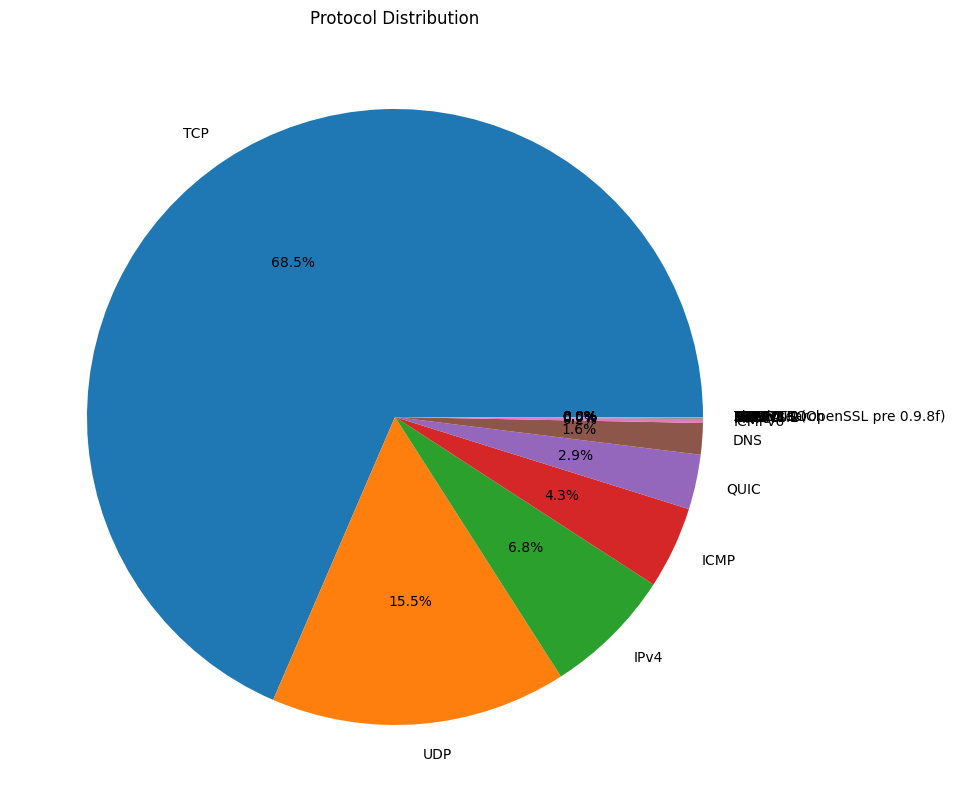

In [57]:
# draw a pie chart for the `_ws.col.Protocol` column
plt.figure(figsize=(10, 10))
plt.pie(df['_ws.col.Protocol'].value_counts(), labels=df['_ws.col.Protocol'].value_counts().index, autopct='%1.1f%%')
plt.title('Protocol Distribution')
plt.show()

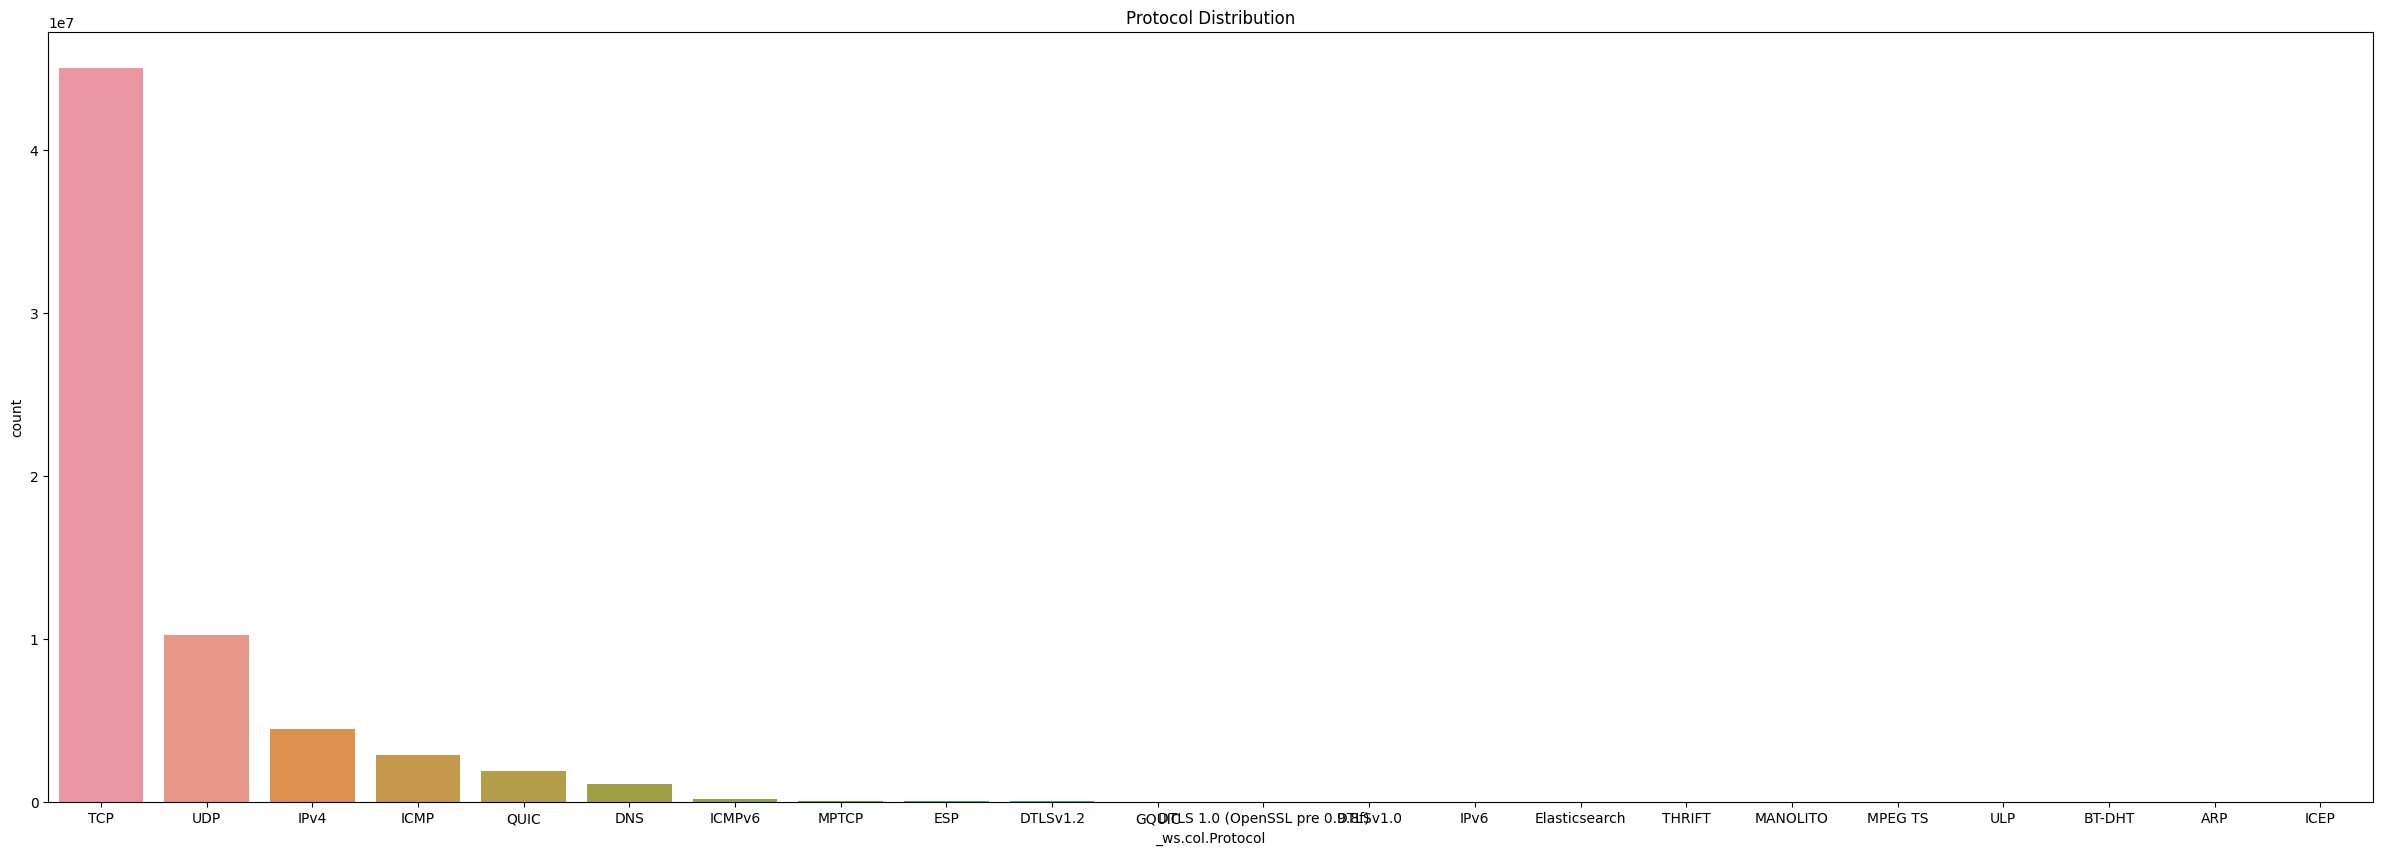

In [61]:
# draw a histogram for the `_ws.col.Protocol` column
plt.figure(figsize=(30, 10))
# make sure the counts are shown above the bars
sns.countplot(x='_ws.col.Protocol', data=df, order=df['_ws.col.Protocol'].value_counts().index)
plt.title('Protocol Distribution')
plt.show()

# 2. Data Summarization

## 2.1 Total no. of flows.

Each flow is determined by the 3-tuple of the following features:
- `_ws.col.Source`
- `_ws.col.Destination`
- `_ws.col.Protocol`

In [42]:
columns_of_interest = ['_ws.col.Source', '_ws.col.Destination', '_ws.col.Protocol']
unique_flows = df[columns_of_interest].drop_duplicates()

# extract the unique flows
num_unique_flows = unique_flows.shape[0]
print("Total no. of unique flows: ", num_unique_flows)

Total no. of unique flows:  8536374


## 2.2. Total duration of flows.

For this, we initially group the data based on flows (by grouping w.r.t. the 3-tuple of the features mentioned above). Then, we find the difference between the maximum and minimum values of the `_ws.col.Time` feature for each group to determine the duration of each flow. Finally, we sum up the durations of all the flows to get the total duration of all the flows.

In [48]:
flows = df.groupby(columns_of_interest)

# find the total duration of each flow
flow_duration = flows['_ws.col.Time'].apply(lambda x: x.max() - x.min())

# find the total duration of all the flows (in seconds)
total_duration = flow_duration.sum()
print("Total duration of all the flows: ", total_duration.total_seconds())

Total duration of all the flows:  0.016976


## 2.3 Total Packet Count

This is just the total sum of the `_ws.col.Length` feature.

In [51]:
# find the sum of 'ws.col.Length' column
total_packet_count = df['_ws.col.Length'].sum()
print("Total no. of packets: ", int(total_packet_count))

Total no. of packets:  49499701248


# 3. Preprocessing

In [52]:
df.describe()

,_ws.col.Time,_ws.col.Length
count,65651093,6.565109e+07
mean,1970-01-01 00:00:00.000000015,7.539814e+02
min,1970-01-01 00:00:00,5.400000e+01
25%,1970-01-01 00:00:00.000000008,6.600000e+01
50%,1970-01-01 00:00:00.000000016,1.480000e+02
75%,1970-01-01 00:00:00.000000023,1.358000e+03
max,1970-01-01 00:00:00.000000037,1.893000e+04
std,NaN,9.773135e+02


## 3.1 Handling Categorical Variables

### 3.1.1 Handling the Target Variable

In this dataset, the target variable is the `_ws.col.Protocol` feature. Since, this is a categorical variable, we need to encode it into numerical values. We use the `LabelEncoder` class from the `sklearn.preprocessing` module to do this.

In [62]:
# check the unique values in the `_ws.col.Protocol` column
df['_ws.col.Protocol'].unique()

array(['IPv4', 'TCP', 'UDP', 'DNS', 'ICMP', 'ICMPv6', 'QUIC', 'GQUIC',
       'ESP', 'ULP', 'DTLSv1.2', 'MPTCP', 'DTLS 1.0 (OpenSSL pre 0.9.8f)',
       'THRIFT', 'DTLSv1.0', 'MPEG TS', 'IPv6', 'Elasticsearch', 'BT-DHT',
       'MANOLITO', 'ICEP', 'ARP'], dtype=object)

In [8]:
# create a dictionary to map the values
protocol_map = {df['_ws.col.Protocol'].value_counts().index[i]: i for i in range(len(df['_ws.col.Protocol'].value_counts()))}

# sort the dictionary based on ascending order of the values
protocol_map = dict(sorted(protocol_map.items(), key=lambda item: item[1]))

# show the protocol map
print(protocol_map)

{'TCP': 0, 'UDP': 1, 'IPv4': 2, 'ICMP': 3, 'QUIC': 4, 'DNS': 5, 'ICMPv6': 6, 'MPTCP': 7, 'ESP': 8, 'DTLSv1.2': 9, 'GQUIC': 10, 'DTLS 1.0 (OpenSSL pre 0.9.8f)': 11, 'DTLSv1.0': 12, 'IPv6': 13, 'Elasticsearch': 14, 'THRIFT': 15, 'MANOLITO': 16, 'MPEG TS': 17, 'ULP': 18, 'BT-DHT': 19, 'ARP': 20, 'ICEP': 21}


In [9]:
# map the values in the `_ws.col.Protocol` column
df['_ws.col.Protocol'] = df['_ws.col.Protocol'].map(protocol_map)

# check the value counts in the `_ws.col.Protocol` column
df['_ws.col.Protocol'].value_counts()

_ws.col.Protocol
0     44988991
1     10193508
2      4459294
3      2837014
4      1886173
5      1082474
6       134548
7        30293
8        27157
9         5897
10        4437
11         680
12         264
13         162
14         101
15          35
16          25
17          24
18          10
19           3
20           2
21           1
Name: count, dtype: int64

In [14]:
# some class labels have very few samples (<20), we combine these classes into a single class
# we create a dictionary to map the values
new_protocol_map = {i:i for i in range(len(protocol_map))}

# we update the new_protocol_map dictionary to reflect the changes
# 19 -> 18, 20 -> 18, 21 -> 18

new_protocol_map[19] = 18
new_protocol_map[20] = 18
new_protocol_map[21] = 18

print(new_protocol_map)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 18, 20: 18, 21: 18}


In [16]:
# check the updated labelings
# map the values in the `_ws.col.Protocol` column
df['_ws.col.Protocol'] = df['_ws.col.Protocol'].map(new_protocol_map)

# check the value counts in the `_ws.col.Protocol` column
df['_ws.col.Protocol'].value_counts()

_ws.col.Protocol
0     44988991
1     10193508
2      4459294
3      2837014
4      1886173
5      1082474
6       134548
7        30293
8        27157
9         5897
10        4437
11         680
12         264
13         162
14         101
15          35
16          25
17          24
18          16
Name: count, dtype: int64

### 3.2.2 Encoding Other Variables

In [17]:
le = LabelEncoder()

categorical_columns = ['_ws.col.Source', '_ws.col.Destination']

# iterate through the columns and encode them
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df.head()

,_ws.col.Time,_ws.col.Source,_ws.col.Destination,_ws.col.Protocol,_ws.col.Length
0,1970-01-01,95665,298516,2,90.0
1,1970-01-01,94318,171355,0,2962.0
2,1970-01-01,116056,243111,1,1292.0
3,1970-01-01,94318,171355,0,1514.0
4,1970-01-01,116056,243111,1,1292.0


In [18]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 3005.27 MB
Memory usage after optimization is: 1815.68 MB
Decreased by 39.6%


In [8]:
# save this dataframe to a csv file
processed_data_path = os.path.join('data', 'processed', 'data_processed.csv')
#df.to_csv(processed_data_path, index=False)

In [9]:
# read the processed data
df = pd.read_csv(processed_data_path)
df.head()

,_ws.col.Time,_ws.col.Source,_ws.col.Destination,_ws.col.Protocol,_ws.col.Length
0,1970-01-01,95665,298516,2,90.0
1,1970-01-01,94318,171355,0,2962.0
2,1970-01-01,116056,243111,1,1292.0
3,1970-01-01,94318,171355,0,1514.0
4,1970-01-01,116056,243111,1,1292.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65651093 entries, 0 to 69190036
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   _ws.col.Time         datetime64[ns]
 1   _ws.col.Source       int32         
 2   _ws.col.Destination  int32         
 3   _ws.col.Protocol     int8          
 4   _ws.col.Length       float32       
dtypes: datetime64[ns](1), float32(1), int32(2), int8(1)
memory usage: 1.8 GB


## 3.3 Splitting Features and Target

In [23]:
# we split the data into features and labels
features = df.drop(columns=['_ws.col.Time', '_ws.col.Protocol'], axis=1)
labels = df['_ws.col.Protocol']

# print the shape of features and labels
print("Shape of features: ", features.shape)
print("Shape of labels: ", labels.shape)

Shape of features:  (65651093, 3)
Shape of labels:  (65651093,)


We have encoded all the nominal columns using the `LabelEncoder`. Now, we need to use `StandardScaler` to scale the data.

In [24]:
# scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## 3.4 Train-Test Split

We split the data into training and testing sets using the `train_test_split` function from `sklearn.model_selection`. We use a `test_size` of `0.2` and use stratified sampling to ensure that the distribution of the target variable is the same in both the training and testing sets.

In [25]:
# stratified split of data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

In [26]:
# check the shape of train and test sets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (52520874, 3)
Shape of y_train:  (52520874,)
Shape of X_test:  (13130219, 3)
Shape of y_test:  (13130219,)


# 4. Model Fit and Evaluation (Predicting Traffic Class)

## 4.1 Logistic Regression

We fit a simple Logistic Regression model to the data. We use the `LogisticRegression` class from `sklearn.linear_model`. We use the `predict` method to predict the target variable for the test set.

In [27]:
%%time

log_reg = LogisticRegression()

# fit the model on train data
log_reg.fit(X_train, y_train)

CPU times: user 1h 5min 33s, sys: 1h 13min 51s, total: 2h 19min 24s
Wall time: 6h 31min 21s


LogisticRegression()

In [28]:
from joblib import dump, load

# save the model to disk
log_reg_save_path = os.path.join('models', 'log_reg.joblib')
#dump(log_reg, log_reg_save_path)

['models/log_reg.joblib']

In [ ]:
# load the model from disk
log_reg = load(log_reg_save_path)

In [ ]:
# predict on the test data
y_test_pred_lr = log_reg.predict(X_test)

## 4.2 Random Forest Classifier

In [7]:
%%time

rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

CPU times: user 2h 10min 23s, sys: 2h 13min 25s, total: 4h 23min 48s
Wall time: 13h 23min 13s


In [ ]:
from joblib import dump, load

# save the model to disk
rfc_save_path = os.path.join('models', 'rfc.joblib')
#dump(rfc, rfc_save_path)

In [ ]:
# load the model from disk
rfc = load(rfc_save_path)

In [ ]:
# predict on the test data
y_test_pred_rf = rfc.predict(X_test)

## 4.3 Classification Report

## 4.4 Accuracy Score

In [32]:
# print the accuracy score of Logistic Regression model
print("Accuracy score: ", accuracy_score(y_test, y_test_pred_lr))

Accuracy score:  0.6852618375976821


In [13]:
# print the accuracy score of Random Forest Classifier model
print("Accuracy score: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy score:  0.971310814662338


## 4.5 Precision Score

In [33]:
# print the weighted precision score of Logistic Regression model
print("Weighted precision score: ", precision_score(y_test, y_test_pred_lr, average='weighted'))

Weighted precision score:  0.4696029016946449


In [14]:
# print the weighted precision score of Random Forest Classifier model
print("Weighted precision score: ", precision_score(y_test, y_test_pred_rf, average='weighted'))

Weighted precision score:  0.970200652643377


## 4.6 Recall Score

In [34]:
# print the weighted recall score of Logistic Regression model
print("Weighted recall score: ", recall_score(y_test, y_test_pred_lr, average='weighted'))

Weighted recall score:  0.6852618375976821


In [16]:
# print the weighted recall score of Random Forest Classifier model
print("Weighted recall score: ", recall_score(y_test, y_test_pred_rf, average='weighted'))

Weighted recall score:  0.971054562747463


## 4.7 Conclusion

We get the following scores for the Logistic Regression model:
- Accuracy: `68.52 %`
- Weighted Precision: `46.96 %`
- Weighted Recall: `68.52 %`

We get the following scores for the Random Forest Classifier model:
- Accuracy: `97.13 %`
- Weighted Precision: `97.02 %`
- Weighted Recall: `99.10 %`

Overall, the Random Forest Classifier model performs much better than the Logistic Regression model. This is because the Random Forest Classifier model is able to capture the non-linear relationships between the features and the target variable much better than the Logistic Regression model.